<a href="https://colab.research.google.com/github/SheshamJoseph/Deep-Learning-with-Tensorflow-ZTM/blob/main/human_or_horses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Humans or Horses...

Here we build a Convolution Neural Network to distinguish whether the content of an image is human or a horse. The dataset used for this project contains over a thousand 300x300 pixel images of horses and humans in different poses. This notebook uses the steps in the book **AI and Machine Learning for Coders**, chapter 3 from page 42, as a guide

### First fetch the dataset and visualize a few images

In [1]:
import zipfile
# Download the training data
!wget -P /content/train_data https://storage.googleapis.com/learning-datasets/horse-or-human.zip

train_zip = "/content/train_data/horse-or-human.zip"

# Unzip the data
zip_ref = zipfile.ZipFile(train_zip, 'r')
zip_ref.extractall(path="/content/train_data/")

zip_ref.close()

--2024-01-13 19:55:17--  https://storage.googleapis.com/learning-datasets/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.207, 173.194.194.207, 173.194.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/content/train_data/horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M   204MB/s    in 0.7s    

2024-01-13 19:55:18 (204 MB/s) - ‘/content/train_data/horse-or-human.zip’ saved [149574867/149574867]



In [2]:
# Walk thtough the folder directories
import os

train_dir = "/content/train_data/"
for dirpath, dirnames, filenames in os.walk(train_dir):
    print(f"There are {len(dirnames)} folders and {len(filenames)} images in {dirpath}")

There are 2 folders and 1 images in /content/train_data/
There are 0 folders and 527 images in /content/train_data/humans
There are 0 folders and 500 images in /content/train_data/horses


In [3]:
# getting the class names
import numpy as np
import pathlib

!rm -rf /content/train_data/horse-or-human.zip
dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in dir.glob('*')]))
print(class_names)

['horses' 'humans']


In [4]:
# Creating a function to randomly plot images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def plot_random_images(target_dir, class_names=class_names):
    plt.figure(figsize=(10,7))
    for i in range(9):
        # setup the target directory
        target_class = random.choice(class_names)
        target_folder = target_dir + target_class
        # select an image
        random_image = random.sample(os.listdir(target_folder), 1)
        image = mpimg.imread(target_folder+'/'+random_image[0])
        # plot the image
        plt.subplot(3, 3, i+1)
        plt.imshow(image)
        plt.title(target_class)
        plt.axis('off')


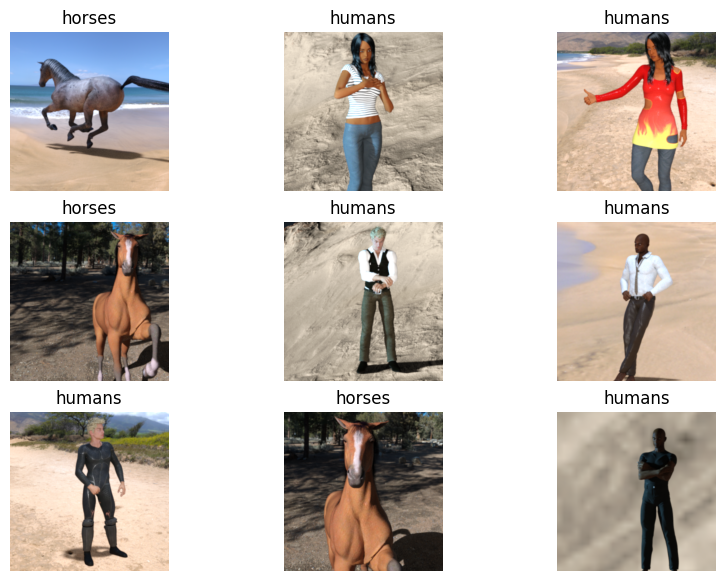

In [5]:
plot_random_images(train_dir)

In [6]:
# Let's also get our validation data
!wget -P /content/valid_data https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip

valid_zip = "/content/valid_data/validation-horse-or-human.zip"

# Unzip the data
zip_ref = zipfile.ZipFile(valid_zip, 'r')
zip_ref.extractall(path="/content/valid_data/")

zip_ref.close()

--2024-01-13 19:55:21--  https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.207, 173.194.194.207, 173.194.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘/content/valid_data/validation-horse-or-human.zip’

validation-horse-or 100%[===================>]  10.95M  --.-KB/s    in 0.1s    

2024-01-13 19:55:21 (106 MB/s) - ‘/content/valid_data/validation-horse-or-human.zip’ saved [11480187/11480187]



In [7]:
# see the contents of the valid data directory
!rm -rf /content/valid_data/validation-horse-or-human.zip
valid_dir = "/content/valid_data/"
for dirpath, dirnames, filenames in os.walk(valid_dir):
    print(f"There are {len(dirnames)} folders and {len(filenames)} images in {dirpath}")

There are 2 folders and 0 images in /content/valid_data/
There are 0 folders and 128 images in /content/valid_data/humans
There are 0 folders and 128 images in /content/valid_data/horses


## Next we load the the data and create a dataset for our model

In [8]:
import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory

image_size = (300, 300)
batch_size = 32
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    label_mode='binary',
    shuffle=True,
    seed=42,
    batch_size=batch_size
)

test_dataset = image_dataset_from_directory(
    valid_dir,
    image_size=image_size,
    label_mode='binary',
    shuffle=True,
    seed=42,
    batch_size=batch_size
)

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Done with loading the data...
Now we build a baseline model and try to beat what ever results we get. For now we will train without augumenting the images.

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Rescaling, Flatten

# set random seed
tf.random.set_seed(42)

# create the model, following TinyVGG's architecture on the CNN Explainer website
model_1 = Sequential([
    Rescaling(1./255, input_shape=(300, 300, 3)),
    Conv2D(10, (3,3), activation='relu'),
    Conv2D(10, (3,3), activation='relu'),
    MaxPool2D(),
    Conv2D(10, (3,3), activation='relu'),
    Conv2D(10, (3,3), activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer="adam",
                metrics=['accuracy'])

# fit the model
hist_1 = model_1.fit(train_dataset, epochs=5,
                     steps_per_epoch=len(train_dataset),
                     validation_data=test_dataset,
                     validation_steps=len(test_dataset))

Epoch 1/5
33/33 [==============================] - 12s 139ms/step - loss: 0.5851 - accuracy: 0.6952 - val_loss: 0.5187 - val_accuracy: 0.7617
Epoch 2/5
33/33 [==============================] - 2s 57ms/step - loss: 0.1844 - accuracy: 0.9435 - val_loss: 1.7047 - val_accuracy: 0.6719
Epoch 3/5
33/33 [==============================] - 2s 55ms/step - loss: 0.1018 - accuracy: 0.9708 - val_loss: 1.3585 - val_accuracy: 0.8008
Epoch 4/5
33/33 [==============================] - 2s 55ms/step - loss: 0.0564 - accuracy: 0.9805 - val_loss: 1.3922 - val_accuracy: 0.8359
Epoch 5/5
33/33 [==============================] - 2s 60ms/step - loss: 0.0313 - accuracy: 0.9912 - val_loss: 1.2241 - val_accuracy: 0.8398


In [11]:
# evaluate the model
model_1.evaluate(test_dataset)

8/8 [==============================] - 0s 21ms/step - loss: 1.2241 - accuracy: 0.8398


[1.2241499423980713, 0.83984375]

<Axes: >

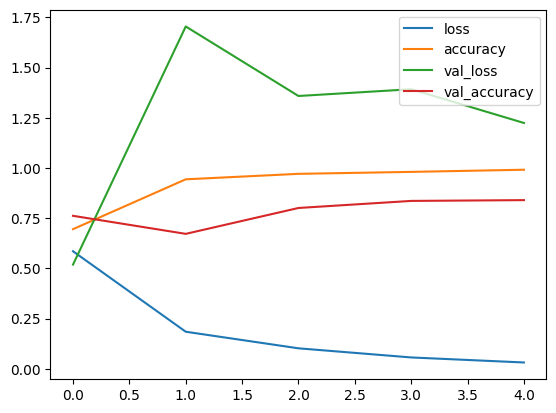

In [12]:
# Check loss curves
import pandas as pd

pd.DataFrame(hist_1.history).plot()

Now to build a function that takes in an image and predicts which class it belongs, we need another function to load and prepare the image for the model (To be used when we build a better model)

In [13]:
class_names

array(['horses', 'humans'], dtype='<U6')

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def load_and_prep_image(filename, img_size=300):
    """
    Reads an image from 'filename', turns it into a tensor and reshapes it to
    (img_size, img_size, color_channels)
    """
    # read in the image
    image = tf.keras.utils.load_img(filename, target_size=(img_size, img_size), color_mode='rgb')
    # decode the image into a tensor
    image_arr = tf.keras.utils.img_to_array(image)
    print(f"Loaded image array shape: {image_arr.shape}")
    # rescale the image
    image_arr = image_arr / 255
    return image_arr

def pred_and_plot(model, filename, class_names):
    """
    Imports an image located at filename, makes a prediction with model
    and plots the image with the predicted class as the title
    """
    print(class_names)
    # Import the target image and preprocess it
    image = load_and_prep_image(filename)
    # Make prediction
    pred = model.predict(np.expand_dims(image, axis=0))
    pred = np.squeeze(pred)
    print(pred)
    # get the predicted class
    # classnames = list(class_names)
    pred_class = class_names[int(tf.round(pred))]
    plt.imshow(image)
    plt.title(pred_class)
    plt.axis(False)
    plt.show()


In [15]:
test_image = "/content/valid_data/horses/horse1-122.png"
image = load_and_prep_image(test_image)
# image = tf.squeeze(image)
image.shape

Loaded image array shape: (300, 300, 3)


(300, 300, 3)

['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 330ms/step
3.5949345e-06


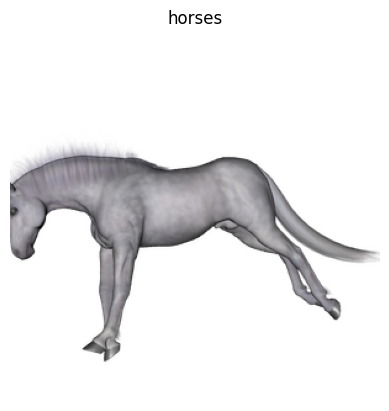

In [16]:
# Choose a random image from the validation folder and make a prediction
import random
folder = "/content/valid_data/"
random_class = random.choice(class_names)
dir = folder + random_class
image = random.sample(os.listdir(dir), 1)
image_path = dir + "/" + image[0]
pred_and_plot(model_1, image_path, class_names)

['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 27ms/step
4.106791e-06


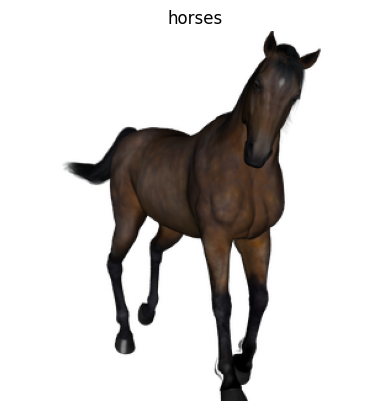

In [17]:
pred_and_plot(model_1, test_image, class_names=class_names)

In [18]:
300*300*4

360000

In [19]:
# upload an image an test model
from google.colab import files

uploaded = files.upload()
uploaded.keys()

Saving horse-197199_1280.jpg to horse-197199_1280.jpg


dict_keys(['horse-197199_1280.jpg'])

['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 18ms/step
4.386619e-06


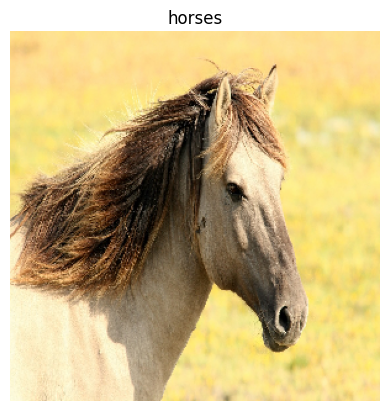

In [20]:
for fn in uploaded.keys():
    pred_and_plot(model_1, filename=fn, class_names=class_names)

The model is doing terribly. So when trying to improve it, I could make changes like:
* Increasing the number of filters in the convolutional layers
* Train longer
* Run data augumentation on the dataset
* Add more hidden layers
* Try another optimizer(maybe rmsprop)

## Applying Data Augumentation to the Dataset

First I create the augumentation layers

In [21]:
from tensorflow import keras
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from keras.models import Sequential

# augumentation layers
image_augumentation = Sequential([
    Rescaling(scale=1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.2)
    # RandomZoom(height_factor=.5, width_factor=.2)
])

# apply to dataset
aug_train_data = train_dataset.map(lambda x,y: (image_augumentation(x, training=True), y))

In [22]:
from keras.layers import Flatten, Conv2D, MaxPool2D, Dense

# creating a model
model_2 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(300, 300, 3)),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    # Add one dense layer before output layer
    # Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_2.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

hist_2 = model_2.fit(aug_train_data,
                     epochs=10, #Train for longer
                     steps_per_epoch=len(aug_train_data),
                     validation_data=test_dataset,
                     validation_steps=len(test_dataset))

Epoch 1/10
33/33 [==============================] - 16s 414ms/step - loss: 0.7823 - accuracy: 0.4771 - val_loss: 0.7096 - val_accuracy: 0.5586
Epoch 2/10
33/33 [==============================] - 14s 423ms/step - loss: 0.6935 - accuracy: 0.4820 - val_loss: 0.7045 - val_accuracy: 0.5625
Epoch 3/10
33/33 [==============================] - 14s 419ms/step - loss: 0.6934 - accuracy: 0.4800 - val_loss: 0.7025 - val_accuracy: 0.5625
Epoch 4/10
33/33 [==============================] - 14s 419ms/step - loss: 0.6934 - accuracy: 0.4898 - val_loss: 0.7022 - val_accuracy: 0.5625
Epoch 5/10
33/33 [==============================] - 14s 423ms/step - loss: 0.6934 - accuracy: 0.4859 - val_loss: 0.7021 - val_accuracy: 0.5625
Epoch 6/10
33/33 [==============================] - 14s 416ms/step - loss: 0.6934 - accuracy: 0.4859 - val_loss: 0.7020 - val_accuracy: 0.5625
Epoch 7/10
33/33 [==============================] - 14s 428ms/step - loss: 0.6934 - accuracy: 0.4859 - val_loss: 0.7020 - val_accuracy: 0.5625

In [23]:
model_2.evaluate(test_dataset)

8/8 [==============================] - 0s 23ms/step - loss: 0.7020 - accuracy: 0.5625


[0.7019979357719421, 0.5625]

<Axes: >

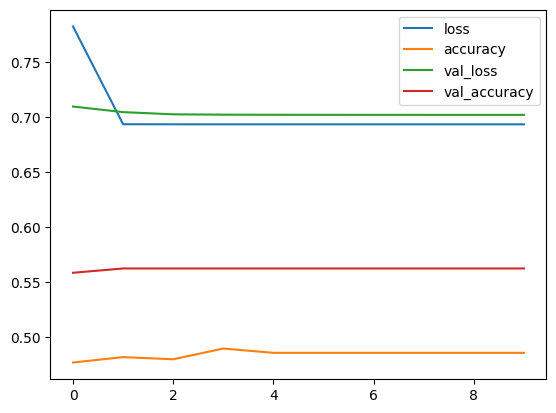

In [24]:
pd.DataFrame(hist_2.history).plot()

In [25]:
import random
def predict_random_image(model):
    folder = "/content/valid_data/"
    random_class = random.choice(class_names)
    dir = folder + random_class
    image = random.sample(os.listdir(dir), 1)
    image_path = dir + "/" + image[0]
    pred_and_plot(model, image_path, class_names)

This model doesn't do any better. So I'll try  building a model identical to the model in the guide book. The model has 5 convolution and max-pooling layers, a flatten layer, a dense layer with 512 neurons and an output layer

In [26]:
# set random seed
tf.random.set_seed(42)

# create the model
model_3 = Sequential([
    # 1st layer
    Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    MaxPool2D(),
    # 2nd Layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPool2D(),
    # 3rd layer
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(),
    # 4th layer
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(),
    # 5th layer
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(),
    Flatten(),
    # Dense layer with 512 neurons
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [27]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 149, 149, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 35, 35, 64)       

In [28]:
len(aug_train_data)

33

In [30]:
# Using RMSPROP() optimizer in the model
model_3.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.RMSprop(),
                metrics=['accuracy'])

# fit the model, without validation
hist_3 = model_3.fit(aug_train_data,
                     epochs=15,
                     steps_per_epoch=len(aug_train_data),
                     validation_data=test_dataset,
                     validation_steps=len(test_dataset))

Epoch 1/15
33/33 [==============================] - 29s 704ms/step - loss: 0.1161 - accuracy: 0.9766 - val_loss: 909.3635 - val_accuracy: 0.5742
Epoch 2/15
33/33 [==============================] - 22s 661ms/step - loss: 0.1419 - accuracy: 0.9640 - val_loss: 259.4963 - val_accuracy: 0.6562
Epoch 3/15
33/33 [==============================] - 14s 415ms/step - loss: 0.0743 - accuracy: 0.9844 - val_loss: 1092.6464 - val_accuracy: 0.5898
Epoch 4/15
33/33 [==============================] - 14s 417ms/step - loss: 0.0367 - accuracy: 0.9893 - val_loss: 131.4330 - val_accuracy: 0.8008
Epoch 5/15
33/33 [==============================] - 14s 436ms/step - loss: 0.0744 - accuracy: 0.9815 - val_loss: 1688.9827 - val_accuracy: 0.5742
Epoch 6/15
33/33 [==============================] - 14s 419ms/step - loss: 0.0662 - accuracy: 0.9805 - val_loss: 726.5453 - val_accuracy: 0.5469
Epoch 7/15
33/33 [==============================] - 15s 464ms/step - loss: 0.0224 - accuracy: 0.9903 - val_loss: 482.5176 - val_

In [31]:
model_3.evaluate(test_dataset)

8/8 [==============================] - 0s 25ms/step - loss: 1646.2527 - accuracy: 0.6016


[1646.252685546875, 0.6015625]

<Axes: >

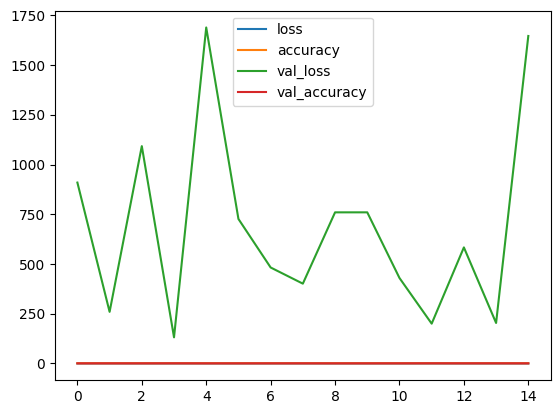

In [32]:
pd.DataFrame(hist_3.history).plot()

['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 38ms/step
1.0


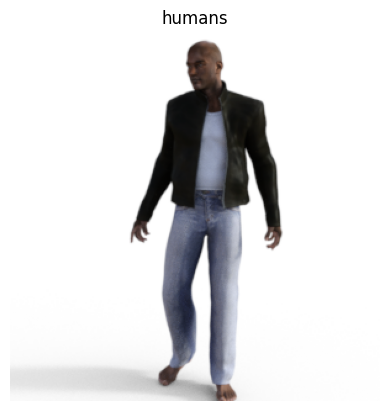

In [39]:
predict_random_image(model_3)

In [40]:
from google.colab import files

def predict_uploaded_image():
    uploaded = files.upload()
    uploaded.keys()
    for fn in uploaded.keys():
        pred_and_plot(model_1, filename=fn, class_names=class_names)


Saving worried-girl-413690_640.jpg to worried-girl-413690_640.jpg
['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 39ms/step
3.6893155e-06


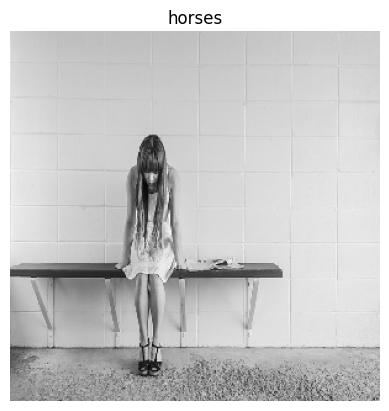

In [41]:
predict_uploaded_image()

Saving horse-197199_1280.jpg to horse-197199_1280 (1).jpg
['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 33ms/step
4.386619e-06


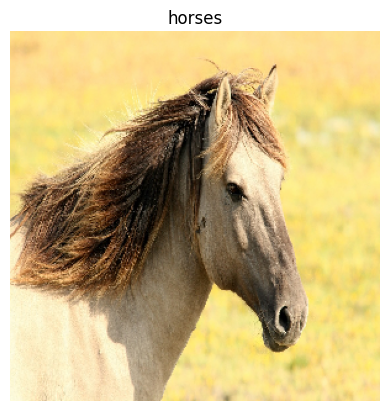

In [42]:
predict_uploaded_image()

Saving people-2591874_640.jpg to people-2591874_640.jpg
['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 19ms/step
3.583078e-06


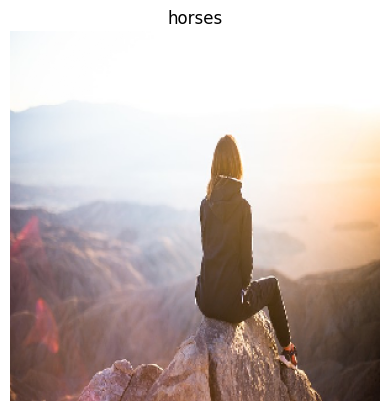

In [43]:
predict_uploaded_image()

Saving white-horse-3010129_1280.jpg to white-horse-3010129_1280.jpg
['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 18ms/step
3.3931935e-06


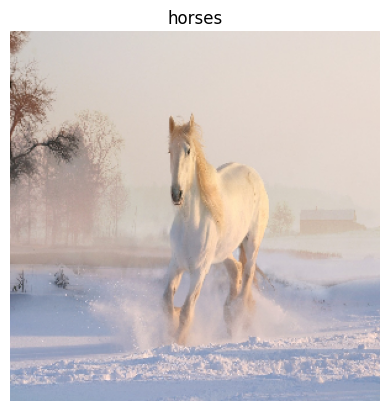

In [46]:
predict_uploaded_image()

The model is still isn't generalizing well, obviously overfitting on the training data so we'll be making more improvements

In [47]:
# set random seed
tf.random.set_seed(42)

# model
model_4 = Sequential([
    # 1st conv
    Conv2D(16, 3, activation='relu', input_shape=(300, 300, 3)),
    MaxPool2D(),
    # 2nd conv
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    # 3rd conv
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# compile
model_4.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.RMSprop(),
                metrics=['accuracy'])

# fit
hist_4 = model_4.fit(aug_train_data,
                     epochs=10,
                     steps_per_epoch=len(aug_train_data))

Epoch 1/10
33/33 [==============================] - 16s 424ms/step - loss: 0.7432 - accuracy: 0.5920
Epoch 2/10
33/33 [==============================] - 14s 413ms/step - loss: 0.4737 - accuracy: 0.7848
Epoch 3/10
33/33 [==============================] - 14s 424ms/step - loss: 0.3993 - accuracy: 0.8403
Epoch 4/10
33/33 [==============================] - 14s 420ms/step - loss: 0.2890 - accuracy: 0.8715
Epoch 5/10
33/33 [==============================] - 14s 416ms/step - loss: 0.2857 - accuracy: 0.8939
Epoch 6/10
33/33 [==============================] - 14s 416ms/step - loss: 0.2058 - accuracy: 0.9163
Epoch 7/10
33/33 [==============================] - 14s 424ms/step - loss: 0.2780 - accuracy: 0.9065
Epoch 8/10
33/33 [==============================] - 14s 418ms/step - loss: 0.1501 - accuracy: 0.9387
Epoch 9/10
33/33 [==============================] - 19s 582ms/step - loss: 0.1434 - accuracy: 0.9484
Epoch 10/10
33/33 [==============================] - 15s 448ms/step - loss: 0.1533 - accura

In [48]:
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 149, 149, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 73, 73, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 35, 35, 64)       

In [49]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 149, 149, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 35, 35, 64)       

In [50]:
model_4.evaluate(test_dataset)

8/8 [==============================] - 0s 34ms/step - loss: 967.7598 - accuracy: 0.5547


[967.759765625, 0.5546875]

In [51]:
model_3.evaluate(test_dataset)

8/8 [==============================] - 0s 29ms/step - loss: 1646.2527 - accuracy: 0.6016


[1646.252685546875, 0.6015625]

['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 104ms/step
0.99951303


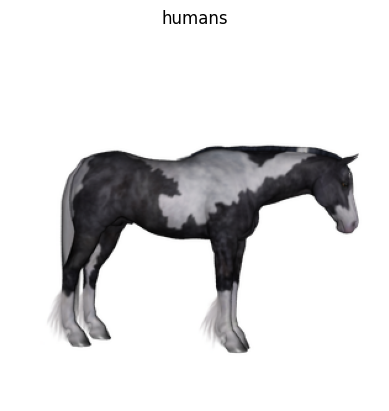

In [52]:
predict_random_image(model_4)

['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 19ms/step
1.0


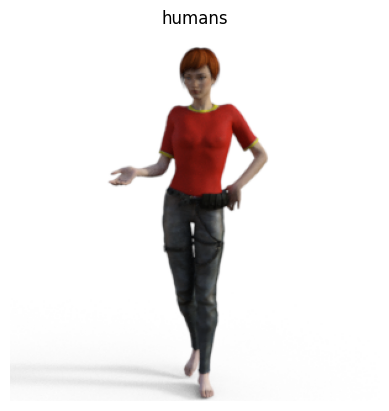

In [54]:
predict_random_image(model_4)

In [65]:
# Build function to plot multiple image and predict what they are
def predict_multiple_images(model):
    """
    Takes in 'model' and plots 9 random images and predicts and labels what the image plotted is.

    """
    plt.figure(figsize=(10, 7))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        predict_random_image(model)

['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 19ms/step
0.9999958


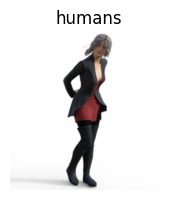

['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 18ms/step
0.9999988


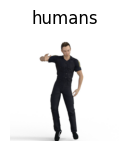

['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 18ms/step
0.023817692


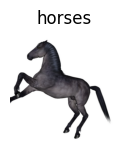

['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 18ms/step
0.99999917


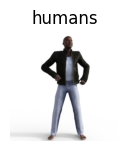

['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 17ms/step
0.9999988


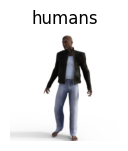

['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 20ms/step
0.99999857


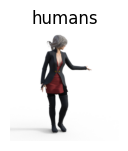

['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 22ms/step
0.9999894


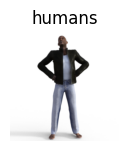

['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 20ms/step
0.9999981


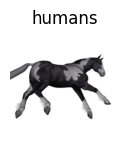

['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 19ms/step
0.99999523


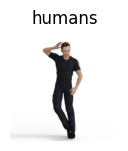

In [67]:
predict_multiple_images(model_4)

The model is doing sort of ok. The plotting function is not functioning as desired. Let's test on images of real humans and horses

Saving people-2591874_640.jpg to people-2591874_640 (1).jpg
['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 38ms/step
3.583078e-06


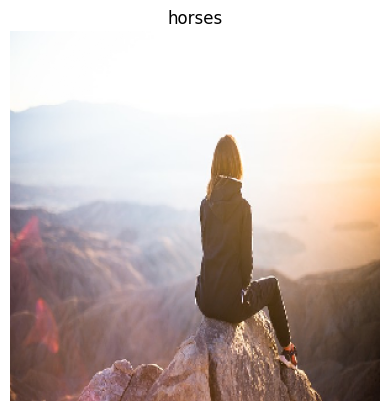

In [68]:
predict_uploaded_image()

Saving portrait-3292287_640.jpg to portrait-3292287_640.jpg
['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 18ms/step
2.7533051e-06


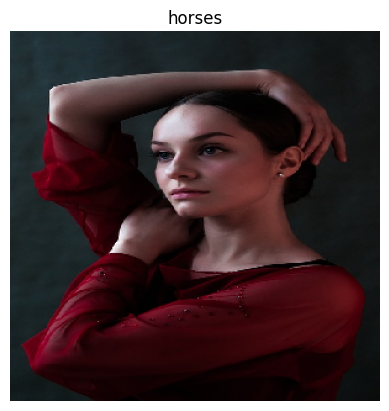

In [69]:
predict_uploaded_image()

Saving girl-1843477_640.jpg to girl-1843477_640.jpg
['horses' 'humans']
Loaded image array shape: (300, 300, 3)
1/1 [==============================] - 0s 18ms/step
2.7595931e-06


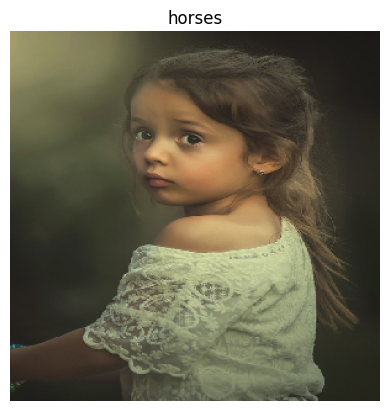

In [70]:
predict_uploaded_image()

The model is still not generalizing well on alien data. I will have to try transfer learning.